In [32]:
import pandas as pd
import numpy as np

In [33]:
!ls ../input/titanic

gender_submission.csv  test.csv  train.csv


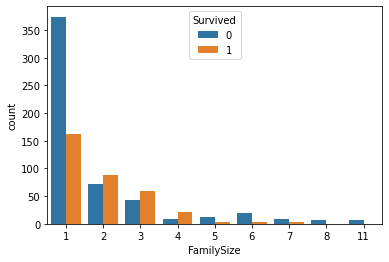

In [34]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
gender_submission = pd.read_csv('../input/titanic/gender_submission.csv')
data = pd.concat([train, test], sort = False )
# visualize
import seaborn as sns
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
train['FamilySize'] = data['FamilySize'][:len(train)]
test['FamilySize'] = data['FamilySize'][len(train):]
sns.countplot(x = 'FamilySize', data = train, hue = 'Survived')
# create newfeatures
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1
# data.loc[True or False, columns] = 1となる
train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]
#train.head()
# is ?
data['Sex'].replace(['male', 'female'],[0,1],inplace =True)
data['Embarked'].str.contains('S').sum()
data['Embarked'].str.contains('C').sum()
data['Embarked'].str.contains('Q').sum()
data['Embarked'].fillna(('Q'), inplace = True)
data['Embarked'] = data['Embarked'].map({'S':0, 'C':1, 'Q':2 }).astype(int)
data['Fare'].fillna(np.mean(data['Fare']), inplace = True)
data['Age'].fillna(data['Age'].median(), inplace=True)
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis = 1, inplace = True)
train = data[:len(train)]
test = data[len(train):]
y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)
X_test = test.drop('Survived', axis = 1)
# LightGBM is necessary for
# dataset split
# category variable is listed
# This is easy to be overlearning 
# The way to solve this is "early stopping"
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.3, random_state = 0, stratify = y_train)
# stratify 層別化する
# stratify = y_test で結果データの値の比率が一致するようになる
# category
categorical_features = ['Embarked', 'Pclass', 'Sex']

In [37]:
# param-adjust
# Tuning tool
# KaggleのKernelに搭載済
import lightgbm as lgb
import optuna
from sklearn.metrics import log_loss


def objective(trial):
    params = {
        'objective': 'binary',
        'max_bin': trial.suggest_int('max_bin', 255, 500),
        'learning_rate': 0.02,
        'num_leaves': trial.suggest_int('num_leaves', 32, 128),
    }

    lgb_train = lgb.Dataset(X_train, y_train,
                            categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_valid, y_valid,
                           reference=lgb_train,
                           categorical_feature=categorical_features)

    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)

    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    score = log_loss(y_valid, y_pred_valid)
    return score

study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials = 60) # objective = def, trials cycle
study.best_params

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:36:54,276] Finished trial#0 with value: 0.4314523979832198 with parameters: {'max_bin': 427, 'num_leaves': 79}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:36:54,770] Finished trial#1 with value: 0.4314523979832198 with parameters: {'max_bin': 372, 'num_leaves': 96}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:36:55,284] Finished trial#2 with value: 0.4314523979832198 with parameters: {'max_bin': 322, 'num_leaves': 99}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:36:55,837] Finished trial#3 with value: 0.4314523979832198 with parameters: {'max_bin': 358, 'num_leaves': 41}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:36:56,351] Finished trial#4 with value: 0.4314523979832198 with parameters: {'max_bin': 466, 'num_leaves': 53}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:36:56,884] Finished trial#5 with value: 0.4314523979832198 with parameters: {'max_bin': 497, 'num_leaves': 68}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:36:57,460] Finished trial#6 with value: 0.4314523979832198 with parameters: {'max_bin': 342, 'num_leaves': 102}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:36:58,667] Finished trial#7 with value: 0.4314523979832198 with parameters: {'max_bin': 471, 'num_leaves': 120}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:36:59,263] Finished trial#8 with value: 0.4314523979832198 with parameters: {'max_bin': 395, 'num_leaves': 90}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:36:59,809] Finished trial#9 with value: 0.4314523979832198 with parameters: {'max_bin': 448, 'num_leaves': 71}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:00,342] Finished trial#10 with value: 0.4314523979832198 with parameters: {'max_bin': 342, 'num_leaves': 78}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:00,861] Finished trial#11 with value: 0.4314523979832198 with parameters: {'max_bin': 343, 'num_leaves': 113}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:01,349] Finished trial#12 with value: 0.4314523979832198 with parameters: {'max_bin': 420, 'num_leaves': 57}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:01,945] Finished trial#13 with value: 0.4314523979832198 with parameters: {'max_bin': 332, 'num_leaves': 104}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:02,451] Finished trial#14 with value: 0.4314523979832198 with parameters: {'max_bin': 264, 'num_leaves': 52}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:03,367] Finished trial#15 with value: 0.4314523979832198 with parameters: {'max_bin': 370, 'num_leaves': 112}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:03,889] Finished trial#16 with value: 0.4314523979832198 with parameters: {'max_bin': 498, 'num_leaves': 101}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:04,437] Finished trial#17 with value: 0.4314523979832198 with parameters: {'max_bin': 334, 'num_leaves': 79}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:04,977] Finished trial#18 with value: 0.4314523979832198 with parameters: {'max_bin': 447, 'num_leaves': 114}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:05,501] Finished trial#19 with value: 0.4314523979832198 with parameters: {'max_bin': 354, 'num_leaves': 120}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:05,997] Finished trial#20 with value: 0.4314523979832198 with parameters: {'max_bin': 432, 'num_leaves': 61}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:06,511] Finished trial#21 with value: 0.4314523979832198 with parameters: {'max_bin': 402, 'num_leaves': 51}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:07,085] Finished trial#22 with value: 0.4314523979832198 with parameters: {'max_bin': 397, 'num_leaves': 71}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:07,869] Finished trial#23 with value: 0.4314523979832198 with parameters: {'max_bin': 287, 'num_leaves': 97}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:08,386] Finished trial#24 with value: 0.4314523979832198 with parameters: {'max_bin': 264, 'num_leaves': 89}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:08,926] Finished trial#25 with value: 0.4314523979832198 with parameters: {'max_bin': 382, 'num_leaves': 64}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:09,454] Finished trial#26 with value: 0.4314523979832198 with parameters: {'max_bin': 286, 'num_leaves': 106}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:09,960] Finished trial#27 with value: 0.4314523979832198 with parameters: {'max_bin': 499, 'num_leaves': 55}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:10,480] Finished trial#28 with value: 0.4314523979832198 with parameters: {'max_bin': 418, 'num_leaves': 107}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:11,000] Finished trial#29 with value: 0.4314523979832198 with parameters: {'max_bin': 369, 'num_leaves': 87}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:11,490] Finished trial#30 with value: 0.4314523979832198 with parameters: {'max_bin': 283, 'num_leaves': 66}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:11,998] Finished trial#31 with value: 0.4314523979832198 with parameters: {'max_bin': 383, 'num_leaves': 32}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:12,634] Finished trial#32 with value: 0.4314523979832198 with parameters: {'max_bin': 419, 'num_leaves': 85}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:13,120] Finished trial#33 with value: 0.4314523979832198 with parameters: {'max_bin': 388, 'num_leaves': 70}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:13,663] Finished trial#34 with value: 0.4314523979832198 with parameters: {'max_bin': 487, 'num_leaves': 49}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:14,164] Finished trial#35 with value: 0.4314523979832198 with parameters: {'max_bin': 334, 'num_leaves': 36}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:14,687] Finished trial#36 with value: 0.4314523979832198 with parameters: {'max_bin': 360, 'num_leaves': 74}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:15,199] Finished trial#37 with value: 0.4314523979832198 with parameters: {'max_bin': 441, 'num_leaves': 63}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:15,720] Finished trial#38 with value: 0.4314523979832198 with parameters: {'max_bin': 375, 'num_leaves': 33}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:16,219] Finished trial#39 with value: 0.4314523979832198 with parameters: {'max_bin': 320, 'num_leaves': 73}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:16,756] Finished trial#40 with value: 0.4314523979832198 with parameters: {'max_bin': 312, 'num_leaves': 67}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:17,228] Finished trial#41 with value: 0.4314523979832198 with parameters: {'max_bin': 357, 'num_leaves': 43}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:18,041] Finished trial#42 with value: 0.4314523979832198 with parameters: {'max_bin': 429, 'num_leaves': 114}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:18,543] Finished trial#43 with value: 0.4314523979832198 with parameters: {'max_bin': 346, 'num_leaves': 32}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:19,062] Finished trial#44 with value: 0.4314523979832198 with parameters: {'max_bin': 397, 'num_leaves': 85}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:19,604] Finished trial#45 with value: 0.4314523979832198 with parameters: {'max_bin': 395, 'num_leaves': 74}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:20,143] Finished trial#46 with value: 0.4314523979832198 with parameters: {'max_bin': 339, 'num_leaves': 107}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:20,788] Finished trial#47 with value: 0.4314523979832198 with parameters: {'max_bin': 323, 'num_leaves': 38}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:21,290] Finished trial#48 with value: 0.4314523979832198 with parameters: {'max_bin': 451, 'num_leaves': 79}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:21,832] Finished trial#49 with value: 0.4314523979832198 with parameters: {'max_bin': 382, 'num_leaves': 35}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:22,323] Finished trial#50 with value: 0.4314523979832198 with parameters: {'max_bin': 459, 'num_leaves': 84}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:23,078] Finished trial#51 with value: 0.4314523979832198 with parameters: {'max_bin': 487, 'num_leaves': 110}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:23,560] Finished trial#52 with value: 0.4314523979832198 with parameters: {'max_bin': 398, 'num_leaves': 52}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:24,045] Finished trial#53 with value: 0.4314523979832198 with parameters: {'max_bin': 482, 'num_leaves': 90}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:24,566] Finished trial#54 with value: 0.4314523979832198 with parameters: {'max_bin': 278, 'num_leaves': 111}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:25,052] Finished trial#55 with value: 0.4314523979832198 with parameters: {'max_bin': 396, 'num_leaves': 117}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:25,583] Finished trial#56 with value: 0.4314523979832198 with parameters: {'max_bin': 303, 'num_leaves': 81}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:26,112] Finished trial#57 with value: 0.4314523979832198 with parameters: {'max_bin': 324, 'num_leaves': 73}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:26,615] Finished trial#58 with value: 0.4314523979832198 with parameters: {'max_bin': 418, 'num_leaves': 96}. Best is trial#0 with value: 0.4314523979832198.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.584307	valid_1's binary_logloss: 0.597093
[20]	training's binary_logloss: 0.528017	valid_1's binary_logloss: 0.549845
[30]	training's binary_logloss: 0.486374	valid_1's binary_logloss: 0.518851
[40]	training's binary_logloss: 0.453841	valid_1's binary_logloss: 0.497711
[50]	training's binary_logloss: 0.426785	valid_1's binary_logloss: 0.480567
[60]	training's binary_logloss: 0.403913	valid_1's binary_logloss: 0.46849
[70]	training's binary_logloss: 0.386024	valid_1's binary_logloss: 0.459808
[80]	training's binary_logloss: 0.37188	valid_1's binary_logloss: 0.452613
[90]	training's binary_logloss: 0.360472	valid_1's binary_logloss: 0.448612
[100]	training's binary_logloss: 0.350556	valid_1's binary_logloss: 0.444755
[110]	training's binary_logloss: 0.34095	valid_1's binary_logloss: 0.442932
[120]	training's binary_logloss: 0.332385	valid_1's binary_logloss: 0.440972
[130]	training's binary_log

[I 2020-07-06 05:37:27,105] Finished trial#59 with value: 0.4314523979832198 with parameters: {'max_bin': 350, 'num_leaves': 101}. Best is trial#0 with value: 0.4314523979832198.


{'max_bin': 427, 'num_leaves': 79}

In [ ]:
# その値を使う
params = {
    'objective': 'binary',
    'max_bin': study.best_params['max_bin'],
    'learning_rate': 0.05,
    'num_leaves': study.best_params['num_leaves']
}

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=1000,
    early_stopping_rounds=10
)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# but score is similar ...

In [24]:
# determine thresh's value y_pred > 0.5 ? 1 : 0
y_pred = (y_pred > 0.5).astype(int)

In [25]:
sub = gender_submission
sub['Survived'] = list(map(int, y_pred))
sub.to_csv('submission.csv', index=False)